In [2]:
!pip install pandas==1.3.5
!pip install sweetviz

  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1
  Using cached sweetviz-2.1.4-py3-none-any.whl (15.1 MB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached importlib_resources-5.8.0-py3-none-any.whl (28 kB)
  Using cached zipp-3.8.0-py3-none-any.whl (5.4 kB)
  Attempting uninstall: zipp
    Found existing installation: zipp 2.2.0
    Uninstalling zipp-2.2.0:
      Successfully uninstalled zipp-2.2.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.42.1
    Uninstalling tqdm-4.42.1:
      Successfully uninstalled tqdm-4.42.1


# Import modules

In [3]:
import io
import boto3
import configparser

import numpy as np
import pandas as pd
import sweetviz as sv

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
def read_csv_from_s3(section_name, bucket_name, file_path, ):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)
    print("Get object")
    obj = s3.get_object(Bucket=bucket_name, Key=file_path)

    print("Read csv")
    df = pd.read_csv( io.BytesIO( obj["Body"].read() ) )
    
    print("Completed")
    print("Data size:", df.shape)

    return df

In [7]:
def write_csv_to_s3(section_name, bucket_name, file_path, data):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)

    print("Put object")
    s3.put_object(
        Body=data.to_csv(index=False).encode(),
        Bucket=bucket_name, Key=file_path)

    print("Completed")

In [5]:
section_name = "aws_boto_credentials"
bucket_name = "ev-depreciation-model"
file_path = "220616_used_car_v1.csv"

df = read_csv_from_s3(section_name, bucket_name, file_path)

Get object
Read csv
Completed
Data size: (374526, 18)


In [6]:
df.fuel.value_counts()

gas         314661
other        27081
diesel       24313
hybrid        4708
electric      1558
Name: fuel, dtype: int64

## Create automatic report

In [10]:
idx_ev = df.fuel.isin(["electric", "hybrid"])

df1 = df.loc[~idx_ev, :].copy()
df2 = df.loc[idx_ev, :].copy()

report = sv.compare([df1, "non-ev"], [df2, "ev"], "price")
report.show_html("compare_fuel.html")

In [11]:
file_path = "220616_used_car_v1_ev.csv"
write_csv_to_s3(section_name, bucket_name, file_path, df2)

Put object
Completed


## Plots

In [9]:
df["ev_yn"] = df["fuel"].apply(lambda x: "ev" if x in ["electric", "hybrid"] else "non_ev")

In [31]:
# manufacturer with only non-ev models
df_grp = df.groupby(["manufacturer", "ev_yn"])["manufacturer"].nunique().unstack().fillna(0)
df_grp[df_grp["ev"]==0]

ev_yn,ev,non_ev
manufacturer,,
alfa-romeo,0.0,1.0
aston-martin,0.0,1.0
buick,0.0,1.0
ferrari,0.0,1.0
harley-davidson,0.0,1.0
morgan,0.0,1.0
pontiac,0.0,1.0


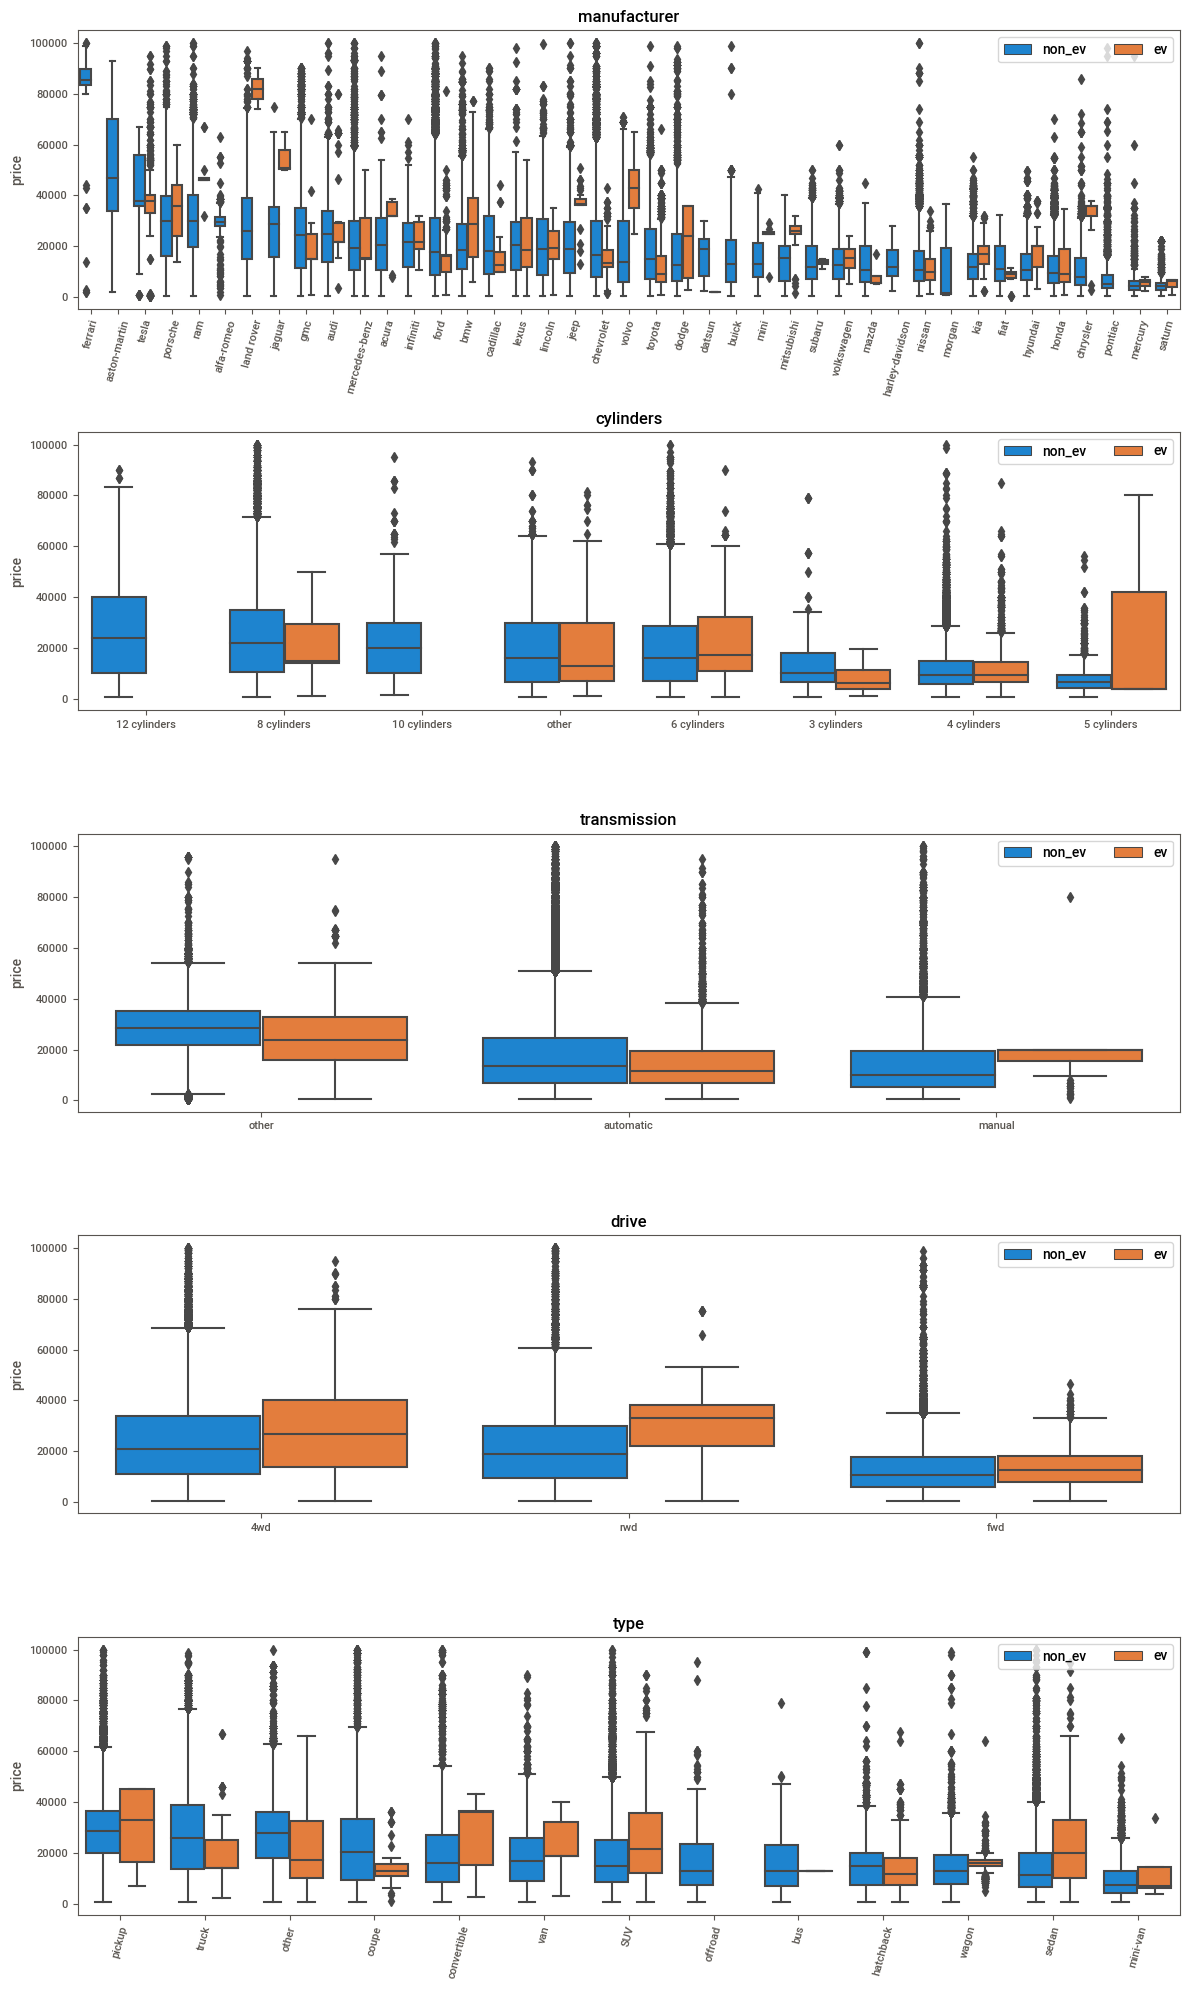

In [27]:
cols = ["manufacturer", "cylinders", "transmission", "drive", "type"]

fig, axs = plt.subplots(figsize=(12,4*len(cols)), nrows=len(cols))
for ax, col in zip(axs.flatten(), cols):
    
    lbs = df.groupby(col)["price"].mean().sort_values(ascending=False).index
    sns.boxplot(x=col, y="price", 
                data=df, hue="ev_yn", 
                order=lbs,
                ax=ax)
    
    ax.set_title(col)
    ax.set_xlabel("")
    ax.legend(ncol=2, loc="upper right")
    if len(lbs)>10:
        ax.set_xticklabels(lbs, rotation=75)
        
plt.tight_layout()
plt.show()